In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from wordfreq import word_frequency
from termcolor import colored
import random
import itertools
import pickle
import math

urlWordle='https://gist.githubusercontent.com/dracos/dd0668f281e685bad51479e5acaadb93/raw/6bfa15d263d6d5b63840a8e5b64e04b382fdb079/valid-wordle-words.txt'
df=pd.read_csv(urlWordle)
wordleAcceptedGuesses=[list(i[0]) for i in df.values]
wordleAcceptedGuesses.append(list('aahed'))
dictLength=len(wordleAcceptedGuesses)

urlAnswers='https://gist.githubusercontent.com/cfreshman/a03ef2cba789d8cf00c08f767e0fad7b/raw/c46f451920d5cf6326d550fb2d6abb1642717852/wordle-answers-alphabetical.txt'
dfa=pd.read_csv(urlAnswers)
wordleAnswers=[list(i[0]) for i in dfa.values]
wordleAnswers.append(list('aback'))

# set probability to binary based on answer list
remainingDict={}
for x in wordleAcceptedGuesses:
    remainingDict.update({''.join(x) : int(x in wordleAnswers)})
weightedProbabilities=remainingDict.copy()

def probWeightfunc(tryNo,ent,p,upTo=10):
    if upTo==0:
        return ent*p
    elif tryNo==0:
        return ent
    elif tryNo>upTo:
        return p*ent
    else:
        return ent*(1-tryNo*(1-p)/upTo)
    
# 2 = green
# 1 = orange 
# 0 = gray
def coloring(word1,answer):
    colorScheme=['']*5
    duplicates=[]
    for indexI,charJ in enumerate(word1):
        if charJ==answer[indexI]:
            colorScheme[indexI]=2
            duplicates.append(charJ)
        elif charJ not in answer:
            colorScheme[indexI]=0
    for indexI,charJ in enumerate(word1):
        counter=0
        counter2=0
        if colorScheme[indexI]==2 or colorScheme[indexI]==0:
            pass
        elif charJ in answer:
            for char in answer:
                if charJ==char:
                    counter+=1
            for char in duplicates:
                if charJ==char:
                    counter2+=1
            if counter>counter2:
                colorScheme[indexI]=1
                duplicates.append(charJ)
            else:
                colorScheme[indexI]=0

    return(colorScheme)

def coloringString(word1,answer):
    colorScheme=['']*5
    duplicates=[]
    for indexI,charJ in enumerate(word1):
        if charJ==answer[indexI]:
            colorScheme[indexI]=2
            duplicates.append(charJ)
        elif charJ not in answer:
            colorScheme[indexI]=0
    for indexI,charJ in enumerate(word1):
        counter=0
        counter2=0
        if colorScheme[indexI]==2 or colorScheme[indexI]==0:
            pass
        elif charJ in answer:
            for char in answer:
                if charJ==char:
                    counter+=1
            for char in duplicates:
                if charJ==char:
                    counter2+=1
            if counter>counter2:
                colorScheme[indexI]=1
                duplicates.append(charJ)
            else:
                colorScheme[indexI]=0

    return(''.join(str(colorScheme)))

def stringToChars(string):
    return [i for i in string]

def charsToString(chars):
    tmp=[i[0] for i in chars]
    return ''.join(tmp)


#Create a lookup for colorings
# pairDict={}
# for w1 in wordleAcceptedGuesses: #[0:size]:
#     for w2 in wordleAnswers: #[0:size]:
#         pairDict.update({charsToString(w1)+charsToString(w2):coloringString(w1,w2)})

# with open('colors_dict_2.pkl', 'wb') as f:
#     pickle.dump(pairDict, f)
with open('colors_dict_2.pkl', 'rb') as f:
    pairDict = pickle.load(f)



def entropyfast(guess,library=wordleAnswers):
    guessString=charsToString(guess)
    dl=len(library)
    histList=[pairDict.get(guessString+charsToString(poss)) if poss in wordleAnswers else 0 for poss in library]
    countList=list(Counter(histList).values())
    return sum(x/dl*math.log2(dl/x) for x in countList)

# Create the entropy dictionary for the first step (14000*2300 calls)
# entropyDictMain={}
# for x in wordleAcceptedGuesses:
#     entropyDictMain.update({''.join(x): entropyfast(x)})

# entropyDictAns={}
# for x in wordleAnswers:
#     entropyDictAns.update({''.join(x): entropyfast(x)})

# with open('saved_dictionary_ans.pkl', 'wb') as f:
#     pickle.dump(entropyDictAns, f)
# with open('saved_dictionary_all.pkl', 'wb') as f:
#     pickle.dump(entropyDictMain, f)

with open('saved_dictionary_all.pkl', 'rb') as f:
    entropyDictMain = pickle.load(f)

with open('saved_dictionary_ans.pkl', 'rb') as f:
    entropyDictAns = pickle.load(f)



def printColorScheme(guess, answer):
    cs=coloring(guess, answer)
    output=''
    for i,j in enumerate(guess):
        if cs[i]==0:
            output+=colored(j,'black',(70, 70, 70))
        elif cs[i]==1:
            output+=colored(j,'black',(200, 170, 100))
        elif cs[i]==2:
            output+=colored(j,'black',(100, 200, 50))
    print(output)

def possibleChoices(state,totaldict):
    infoExistsButNotHere=state[0]
    infoNotExists=state[1]
    infoPosition=state[2]
    def notatposition(char,*pos):
        arr=['']*5
        for i in pos:
            arr[i-1]=char
        return arr
    def atposition(pos):
        temp=[list(i) for i in pos if i !='']
        arr=['']*5
        for i in temp:
            arr[int(i[1])-1]=i[0]
        return arr

    tl1=[list(i) for i in infoExistsButNotHere]
    tl2=[]
    for i in tl1:
        tl2.append(notatposition(i[0],int(i[1])))

    infoPosition=atposition(infoPosition)
    #infoExistsButNotHere=[list(i) for i in infoExistsButNotHere]
    stillIn=totaldict.copy()
    for word in totaldict:
        flag=False
        for j in tl2:
            for k in j:
                if k!='' and k not in word:
                    flag=True
        if infoNotExists!=[]:
            for j in infoNotExists:
                if j in word:
                    flag=True

        for k,l in enumerate(infoPosition):
            if l!='' and word[k]!=l:
                flag=True

        for conds in tl2:
            for k,l in enumerate(conds):
                if l!='' and word[k]==l:
                    flag=True

        if flag:
            stillIn.remove(word)
    #print(f'Remaining options: {len(stillIn)}')
    return stillIn

def newInfo(guess,colorsReturned,printfunc=False):
    localinfo=[[],[],[]]
    doubles=[x for x in guess if guess.count(x) > 1]
    flagGreen={}
    flagOrange={}
    if printfunc:
        print(flagGreen)
        print(flagOrange)
        print(doubles)
    for i,j in enumerate(guess):
        if colorsReturned[i]==2:   # green entries
            localinfo[2].append(j+str(i+1))
            localinfo[2] = list(dict.fromkeys(localinfo[2]))
            if j in doubles:
                doubles.remove(j)
                flagGreen.update({i:j})
        
    for i,j in enumerate(guess):
        if colorsReturned[i]==1:    # orange entries
            localinfo[0].append(j+str(i+1))
            localinfo[0] = list(dict.fromkeys(localinfo[0]))
            if j in doubles:
                doubles.remove(j)
                flagOrange.update({i:j})

    for i,j in enumerate(guess):       
        if colorsReturned[i]==0:     # gray entries
            # if j not in doubles:
            #     localinfo[1].append(j)
            #     localinfo[1] = list(dict.fromkeys(localinfo[1]))
            if j in doubles and j in flagGreen.values() and j not in flagOrange.values():
                keys=[key for key, val in flagGreen.items() if val == j]
                for q in range(5):
                    if printfunc:
                        print(flagGreen)
                        print(flagOrange)
                    if q not in keys:
                        localinfo[0].append(j+str(q+1))
                        localinfo[0] = list(dict.fromkeys(localinfo[0]))
            elif j in doubles and j in flagOrange.values() and j not in flagGreen.values():
                localinfo[0].append(j+str(i+1))
                localinfo[0] = list(dict.fromkeys(localinfo[0]))
            elif j in doubles and j in flagGreen.values() and j in flagOrange.values():
                localinfo[0].append(j+str(i+1))
                localinfo[0] = list(dict.fromkeys(localinfo[0]))
            else:
                localinfo[1].append(j)
                localinfo[1] = list(dict.fromkeys(localinfo[1]))

    if printfunc:
        print(flagGreen)
        print(flagOrange)
        print(doubles)
   
    return localinfo



def nextGuessIt(knowledge,tryNo,printBool=False):

    pc=possibleChoices(knowledge,wordleAnswers)
    if printBool:
        #print(knowledge)
        print(f'remaining: {len(pc)}')
    if len(pc)==0:
        return -1
    if len(pc)==1:
        return charsToString(pc[0])
    #print(pc)

    remainingDict={}
    for x in wordleAcceptedGuesses:
        word=''.join(x)
        prob=(x in pc)
        if tryNo==0:
            ent=entropyDictMain.get(word)
        else:    
            ent=entropyfast(x,pc)
        remainingDict.update({word : ent*(1+0.00001*prob)})    #probWeightfunc(tryNo,ent,prob,upToWeight)
        # options: consider just entropy:    join(x) : ent
                                                    # options: consider entropy and only use words in answers:    join(x) : ent*prob
                                                    # options: consider entropy and only use words in answers, but perfect start:    join(x) : ent*probWeightfunc(tryNo,ent,prob,1)
                                                    # options: consider weight function between both:    join(x) : ent*probWeightfunc(tryNo,ent,prob,3)

    #sortedListSub=sorted(remainingDict.items(), key=lambda x: -x[1])
    if printBool:
        #print(f'Remaining options: {len(remainingDict)}')
        print(f'remaining list: {[(charsToString(x),remainingDict.get(charsToString(x))) for x in pc]}')
        print(f'best option: {max(remainingDict, key=remainingDict.get)}')
    return max(remainingDict, key=remainingDict.get)

def playGame(answer=random.choice(wordleAnswers),printColors=True,printStats=False):
    states=[newInfo('',[0,0,0,0,0]),
        newInfo('',[0,0,0,0,0]),
        newInfo('',[0,0,0,0,0]),    
        newInfo('',[0,0,0,0,0]),
        newInfo('',[0,0,0,0,0]),
        newInfo('',[0,0,0,0,0])] #newInfo('poker',[0,0,0,2,0]),newInfo('north',[1,0,0,0,0]),newInfo('seven',[0,0,1,2,2])
    for i in range(6):
        knowledge=[[val for row in [x[0] for x in states] for val in row],
                   [val for row in [x[1] for x in states] for val in row],
                   [val for row in [x[2] for x in states] for val in row]]
        ng=nextGuessIt(knowledge,i,printBool=printStats)
        if ng==-1:
            if printColors:
                print('No solution found')
            return 7
        nextGuess=stringToChars(ng)
        if printColors:
            printColorScheme(nextGuess,answer)
        if nextGuess==answer:
            return i+1
        else:
            states[i]=newInfo(nextGuess,coloring(nextGuess,answer))
        #print(states)
    return 7
playGame(stringToChars('shalt'),printColors=True)

tarse
linch
shalt


3

In [104]:

playGame(stringToChars('splat'),printColors=True)

tarse
linch
stalk
splat


4

In [ ]:
# Create Lookup Tables Manually
# pairDict={}
# for w1 in wordleAcceptedGuesses: #[0:size]:
#     for w2 in wordleAnswers: #[0:size]:
#         pairDict.update({charsToString(w1)+charsToString(w2):coloringString(w1,w2)})

# with open('colors_dict_2.pkl', 'wb') as f:
#     pickle.dump(pairDict, f)

# entropyDictMain={}
# for x in wordleAcceptedGuesses:
#     entropyDictMain.update({''.join(x): entropyfast(x)})

# entropyDictAns={}
# for x in wordleAnswers:
#     entropyDictAns.update({''.join(x): entropyfast(x)})

# with open('saved_dictionary_ans.pkl', 'wb') as f:
#     pickle.dump(entropyDictAns, f)
# with open('saved_dictionary_all.pkl', 'wb') as f:
#     pickle.dump(entropyDictMain, f)

In [99]:
def nextGuessIt(knowledge,tryNo,printBool=False,returnNum=False):   
    pcAll=possibleChoices(knowledge,wordleAcceptedGuesses)
    pcAns=possibleChoices(knowledge,wordleAnswers)

    # if len(pc)==0:
    #     if returnNum:
    #         return (0,-1)
    #     else:
    #         return -1
    if len(pcAns)==1:
        if returnNum:
            return (1,charsToString(pcAns[0]))
        else:
            return charsToString(pcAns[0])
    if len(pcAns)>0:    
        remainingDict={}
        for x in wordleAcceptedGuesses:
            word=''.join(x)
            prob=(x in pcAns)
            if tryNo==0:
                ent=entropyDictMain.get(word)
            else:
                ent=entropyfast(x,pcAns)
            remainingDict.update({word : ent*(1+0.00001*prob)})
            sortedListSub=sorted(remainingDict.items(), key=lambda x: -x[1])
        
    else:
        remainingDict={}
        for x in wordleAcceptedGuesses:
            word=''.join(x)
            ent=entropyfast(x,pcAll)
            remainingDict.update({word : ent})
            sortedListSub=sorted(remainingDict.items(), key=lambda x: -x[1])
    
    print(f'remainingDict length: {len(remainingDict)}')
    print(f'sorted list length: {len(sortedListSub)}')
    if returnNum:
        return (len(pcAns),sortedListSub) 
    else:
        return sortedListSub #max(remainingDict, key=remainingDict.get)
    

def playGame(answer=random.choice(wordleAnswers),printColors=True,printStats=False):
    states=[newInfo('',[0,0,0,0,0]),
        newInfo('',[0,0,0,0,0]),
        newInfo('',[0,0,0,0,0]),    
        newInfo('',[0,0,0,0,0]),
        newInfo('',[0,0,0,0,0]),
        newInfo('',[0,0,0,0,0])] #newInfo('poker',[0,0,0,2,0]),newInfo('north',[1,0,0,0,0]),newInfo('seven',[0,0,1,2,2])
    for i in range(6):
        knowledge=[[val for row in [x[0] for x in states] for val in row],
                [val for row in [x[1] for x in states] for val in row],
                [val for row in [x[2] for x in states] for val in row]]
        ng=nextGuessIt(knowledge,i,printBool=printStats)
        if ng==-1:
            if printColors:
                print('No solution found')
            return 7
        nextGuess=stringToChars(ng)
        if printColors:
            printColorScheme(nextGuess,answer)
        if nextGuess==answer:
            return i+1
        else:
            states[i]=newInfo(nextGuess,coloring(nextGuess,answer))
        #print(states)
    return 7

def nextGuess(*args):
    numappend=(12-len(args))//2
    argspad=[x for x in args]
    for i in range(numappend):
        argspad.append('')
        argspad.append([0,0,0,0,0])
    states6=[[[argspad[0]],argspad[1]],
            [[argspad[2]],argspad[3]],
            [[argspad[4]],argspad[5]],
            [[argspad[6]],argspad[7]],
            [[argspad[8]],argspad[9]],
            [[argspad[10]],argspad[11]]]
    states=[]
    for i in states6:
        if i[0]!=['']:
            states.append(newInfo(i[0][0],i[1]))

    knowledge=[[val for row in [x[0] for x in states] for val in row],[val for row in [x[1] for x in states] for val in row],[val for row in [x[2] for x in states] for val in row]]
    return nextGuessIt(knowledge,len(states),printBool=False,returnNum=True)

In [87]:
print(entropyfast('smalt',wordleAnswers))

5.143608943420567


In [ ]:
def playSomeGames(num,weight):
    performance=[]
    temp=random.choices(wordleAnswers,k=num)
    for i in temp:
        performance.append(playGame(i,upToWeight=weight,printColors=False))
    return np.mean(performance).item()

In [ ]:
# # estimate probability based on word occurrence in natural language
# remainingDict={}
# for x in wordleAcceptedGuesses:
#     temp=word_frequency(''.join(x), 'en')
#     prob=1/(1 + np.exp(-(temp-1e-6)/0.0000001))
#     remainingDict.update({''.join(x) : prob.item()})
# weightedProbabilities=remainingDict.copy()
# best first guess is 'rates'

In [430]:
def playUntilYouLose():
    for i in wordleAnswers[0:100]:
        if playGame(i,printColors=False)==7:
            print(i)
            break
playUntilYouLose()

In [ ]:
[print(key) for key, val in entAndBiasFixed.items() if val == 6]

hover
poker


[None, None]

In [ ]:
def playAllGames():
    performance={}
    for i in wordleAnswers:
        performance.update({charsToString(i):playGame(i,printColors=False)})
    return performance

entAndBiasFixed=playAllGames()

with open('performanceLog.pkl', 'wb') as f:
    pickle.dump(entAndBiasFixed, f)

In [ ]:
with open('performanceLog.pkl', 'rb') as f:
    entAndBiasFixed = pickle.load(f)

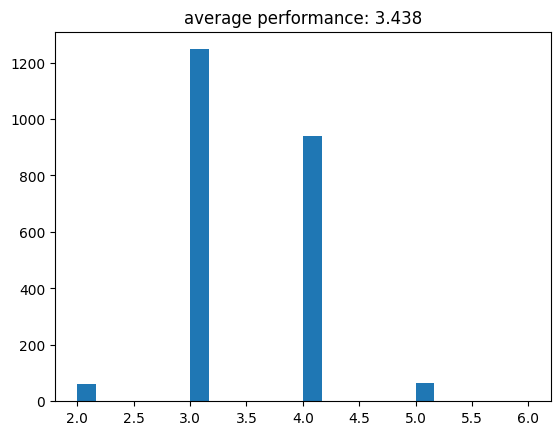

In [5]:
plt.hist(entAndBiasFixed.values(), bins=24)
plt.title(f'average performance: {round(np.mean(np.mean(list(entAndBiasFixed.values()))),3)}') #metric: entropy, bias towards x in pc, entropy gets updated
plt.show() 

In [100]:
# How to actually be helpful in a game:
states6=[[['tarse'],[1,1,0,1,0]],
         [['linch'],[1,0,0,0,0]],
         [[''],[0,0,0,0,0]],
         [[''],[0,0,0,0,0]],
         [[''],[0,0,0,0,0]],
         [[''],[0,0,0,0,0]]]
states=[]
for i in states6:
    if i[0]!=['']:
        states.append(newInfo(i[0][0],i[1]))

knowledge=[[val for row in [x[0] for x in states] for val in row],[val for row in [x[1] for x in states] for val in row],[val for row in [x[2] for x in states] for val in row]]
print(nextGuessIt(knowledge,2,returnNum=True))
print(possibleChoices(knowledge,wordleAnswers))
print(knowledge)


remainingDict length: 14855
sorted list length: 14855
(3, [('stalk', 1.5849783503461632), ('stall', 1.5849783503461632), ('aback', 1.5849625007211559), ('abaka', 1.5849625007211559), ('abask', 1.5849625007211559), ('acral', 1.5849625007211559), ('ahull', 1.5849625007211559), ('aimak', 1.5849625007211559), ('akara', 1.5849625007211559), ('akela', 1.5849625007211559), ('akkas', 1.5849625007211559), ('alack', 1.5849625007211559), ('alala', 1.5849625007211559), ('aleak', 1.5849625007211559), ('algal', 1.5849625007211559), ('alkyl', 1.5849625007211559), ('allan', 1.5849625007211559), ('allay', 1.5849625007211559), ('allee', 1.5849625007211559), ('allel', 1.5849625007211559), ('allen', 1.5849625007211559), ('aller', 1.5849625007211559), ('alley', 1.5849625007211559), ('allin', 1.5849625007211559), ('allis', 1.5849625007211559), ('allod', 1.5849625007211559), ('allot', 1.5849625007211559), ('allow', 1.5849625007211559), ('alloy', 1.5849625007211559), ('allus', 1.5849625007211559), ('allyl', 1

In [102]:

playGame(stringToChars('splat'))

remainingDict length: 14855
sorted list length: 14855


IndexError: list index out of range

In [101]:
stringToChars('splat') in wordleAnswers

True

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from wordfreq import word_frequency
from termcolor import colored
import random
import itertools
import pickle
import math

class WordleBot():
    urlWordle='https://gist.githubusercontent.com/dracos/dd0668f281e685bad51479e5acaadb93/raw/6bfa15d263d6d5b63840a8e5b64e04b382fdb079/valid-wordle-words.txt'
    df=pd.read_csv(urlWordle)
    wordleAcceptedGuesses=[list(i[0]) for i in df.values]
    wordleAcceptedGuesses.append(list('aahed'))
    dictLength=len(wordleAcceptedGuesses)
    urlAnswers='https://gist.githubusercontent.com/cfreshman/a03ef2cba789d8cf00c08f767e0fad7b/raw/c46f451920d5cf6326d550fb2d6abb1642717852/wordle-answers-alphabetical.txt'
    dfa=pd.read_csv(urlAnswers)
    wordleAnswers=[list(i[0]) for i in dfa.values]
    wordleAnswers.append(list('aback'))
    
    def __init__():
        pass
    

    def probWeightfunc(tryNo,ent,p,upTo=10):
        if upTo==0:
            return ent*p
        elif tryNo==0:
            return ent
        elif tryNo>upTo:
            return p*ent
        else:
            return ent*(1-tryNo*(1-p)/upTo)



    def coloring(word1,answer):
        colorScheme=['']*5
        duplicates=[]
        for indexI,charJ in enumerate(word1):
            if charJ==answer[indexI]:
                colorScheme[indexI]=2
                duplicates.append(charJ)
            elif charJ not in answer:
                colorScheme[indexI]=0
        for indexI,charJ in enumerate(word1):
            counter=0
            counter2=0
            if colorScheme[indexI]==2 or colorScheme[indexI]==0:
                pass
            elif charJ in answer:
                for char in answer:
                    if charJ==char:
                        counter+=1
                for char in duplicates:
                    if charJ==char:
                        counter2+=1
                if counter>counter2:
                    colorScheme[indexI]=1
                    duplicates.append(charJ)
                else:
                    colorScheme[indexI]=0

        return(colorScheme)

    def coloringString(word1,answer):
        colorScheme=['']*5
        duplicates=[]
        for indexI,charJ in enumerate(word1):
            if charJ==answer[indexI]:
                colorScheme[indexI]=2
                duplicates.append(charJ)
            elif charJ not in answer:
                colorScheme[indexI]=0
        for indexI,charJ in enumerate(word1):
            counter=0
            counter2=0
            if colorScheme[indexI]==2 or colorScheme[indexI]==0:
                pass
            elif charJ in answer:
                for char in answer:
                    if charJ==char:
                        counter+=1
                for char in duplicates:
                    if charJ==char:
                        counter2+=1
                if counter>counter2:
                    colorScheme[indexI]=1
                    duplicates.append(charJ)
                else:
                    colorScheme[indexI]=0

        return(''.join(str(colorScheme)))

    def stringToChars(string):
        return [i for i in string]

    def charsToString(chars):
        tmp=[i[0] for i in chars]
        return ''.join(tmp)


    #Create a lookup for colorings
    # pairDict={}
    # for w1 in wordleAcceptedGuesses: #[0:size]:
    #     for w2 in wordleAnswers: #[0:size]:
    #         pairDict.update({charsToString(w1)+charsToString(w2):coloringString(w1,w2)})

    # with open('colors_dict_2.pkl', 'wb') as f:
    #     pickle.dump(pairDict, f)
    with open('colors_dict_2.pkl', 'rb') as f:
        pairDict = pickle.load(f)



    def entropyfast(guess,library=wordleAnswers):
        guessString=charsToString(guess)
        dl=len(library)
        histList=[pairDict.get(guessString+charsToString(poss)) for poss in library]
        countList=list(Counter(histList).values())
        return sum(x/dl*math.log2(dl/x) for x in countList)

    # Create the entropy dictionary for the first step (14000*2300 calls)
    # entropyDictMain={}
    # for x in wordleAcceptedGuesses:
    #     entropyDictMain.update({''.join(x): entropyfast(x)})

    # entropyDictAns={}
    # for x in wordleAnswers:
    #     entropyDictAns.update({''.join(x): entropyfast(x)})

    # with open('saved_dictionary_ans.pkl', 'wb') as f:
    #     pickle.dump(entropyDictAns, f)
    # with open('saved_dictionary_all.pkl', 'wb') as f:
    #     pickle.dump(entropyDictMain, f)

    with open('saved_dictionary_all.pkl', 'rb') as f:
        entropyDictMain = pickle.load(f)

    with open('saved_dictionary_ans.pkl', 'rb') as f:
        entropyDictAns = pickle.load(f)



    def printColorScheme(guess, answer):
        cs=coloring(guess, answer)
        output=''
        for i,j in enumerate(guess):
            if cs[i]==0:
                output+=colored(j,'black',(70, 70, 70))
            elif cs[i]==1:
                output+=colored(j,'black',(200, 170, 100))
            elif cs[i]==2:
                output+=colored(j,'black',(100, 200, 50))
        print(output)

    def possibleChoices(state,totaldict):
        infoExistsButNotHere=state[0]
        infoNotExists=state[1]
        infoPosition=state[2]
        def notatposition(char,*pos):
            arr=['']*5
            for i in pos:
                arr[i-1]=char
            return arr
        def atposition(pos):
            temp=[list(i) for i in pos if i !='']
            arr=['']*5
            for i in temp:
                arr[int(i[1])-1]=i[0]
            return arr

        tl1=[list(i) for i in infoExistsButNotHere]
        tl2=[]
        for i in tl1:
            tl2.append(notatposition(i[0],int(i[1])))

        infoPosition=atposition(infoPosition)

        stillIn=totaldict.copy()
        for word in totaldict:
            flag=False
            for j in tl2:
                for k in j:
                    if k!='' and k not in word:
                        flag=True
            if infoNotExists!=[]:
                for j in infoNotExists:
                    if j in word:
                        flag=True

            for k,l in enumerate(infoPosition):
                if l!='' and word[k]!=l:
                    flag=True

            for conds in tl2:
                for k,l in enumerate(conds):
                    if l!='' and word[k]==l:
                        flag=True

            if flag:
                stillIn.remove(word)
        #print(f'Remaining options: {len(stillIn)}')
        return stillIn

    def newInfo(guess,colorsReturned,printfunc=False):
        localinfo=[[],[],[]]
        doubles=[x for x in guess if guess.count(x) > 1]
        flagGreen={}
        flagOrange={}
        if printfunc:
            print(flagGreen)
            print(flagOrange)
            print(doubles)
        for i,j in enumerate(guess):
            if colorsReturned[i]==2:   # green entries
                localinfo[2].append(j+str(i+1))
                localinfo[2] = list(dict.fromkeys(localinfo[2]))
                if j in doubles:
                    doubles.remove(j)
                    flagGreen.update({i:j})
            
        for i,j in enumerate(guess):
            if colorsReturned[i]==1:    # orange entries
                localinfo[0].append(j+str(i+1))
                localinfo[0] = list(dict.fromkeys(localinfo[0]))
                if j in doubles:
                    doubles.remove(j)
                    flagOrange.update({i:j})

        for i,j in enumerate(guess):       
            if colorsReturned[i]==0:     # gray entries

                if j in doubles and j in flagGreen.values() and j not in flagOrange.values():
                    keys=[key for key, val in flagGreen.items() if val == j]
                    for q in range(5):
                        if printfunc:
                            print(flagGreen)
                            print(flagOrange)
                        if q not in keys:
                            localinfo[0].append(j+str(q+1))
                            localinfo[0] = list(dict.fromkeys(localinfo[0]))
                elif j in doubles and j in flagOrange.values() and j not in flagGreen.values():
                    localinfo[0].append(j+str(i+1))
                    localinfo[0] = list(dict.fromkeys(localinfo[0]))
                elif j in doubles and j in flagGreen.values() and j in flagOrange.values():
                    localinfo[0].append(j+str(i+1))
                    localinfo[0] = list(dict.fromkeys(localinfo[0]))
                else:
                    localinfo[1].append(j)
                    localinfo[1] = list(dict.fromkeys(localinfo[1]))

        if printfunc:
            print(flagGreen)
            print(flagOrange)
            print(doubles)
    
        return localinfo



    def nextGuessIt(knowledge,tryNo,upToWeight,printBool=False,returnNum=False):
        testlist=wordleAcceptedGuesses    
        pc=possibleChoices(knowledge,wordleAnswers)
        if printBool:
            #print(knowledge)
            print(f'remaining: {len(pc)}')
        if len(pc)==0:
            return -1
        if len(pc)==1:
            return charsToString(pc[0])
        #print(pc)

        remainingDict={}
        for x in wordleAcceptedGuesses:
            word=''.join(x)
            prob=(x in pc)
            if tryNo==0:
                ent=entropyDictMain.get(word)
            else:    
                ent=entropyfast(x,pc)
            remainingDict.update({word : ent*(1+0.00001*prob)})    #probWeightfunc(tryNo,ent,prob,upToWeight)
            # options: consider just entropy:    join(x) : ent
                                                        # options: consider entropy and only use words in answers:    join(x) : ent*prob
                                                        # options: consider entropy and only use words in answers, but perfect start:    join(x) : ent*probWeightfunc(tryNo,ent,prob,1)
                                                        # options: consider weight function between both:    join(x) : ent*probWeightfunc(tryNo,ent,prob,3)

        #sortedListSub=sorted(remainingDict.items(), key=lambda x: -x[1])
        if printBool:
            #print(f'Remaining options: {len(remainingDict)}')
            print(f'remaining list: {[(charsToString(x),remainingDict.get(charsToString(x))) for x in pc]}')
            print(f'best option: {max(remainingDict, key=remainingDict.get)}')
        if returnNum:
            return (len(pc),max(remainingDict, key=remainingDict.get)) 
        else:
            return max(remainingDict, key=remainingDict.get)

    def playGame(answer=random.choice(wordleAnswers),upToWeight=3,printColors=True,printStats=False):
        states=[newInfo('',[0,0,0,0,0]),
            newInfo('',[0,0,0,0,0]),
            newInfo('',[0,0,0,0,0]),    
            newInfo('',[0,0,0,0,0]),
            newInfo('',[0,0,0,0,0]),
            newInfo('',[0,0,0,0,0])] #newInfo('poker',[0,0,0,2,0]),newInfo('north',[1,0,0,0,0]),newInfo('seven',[0,0,1,2,2])
        for i in range(6):
            knowledge=[[val for row in [x[0] for x in states] for val in row],
                    [val for row in [x[1] for x in states] for val in row],
                    [val for row in [x[2] for x in states] for val in row]]
            ng=nextGuessIt(knowledge,i,upToWeight,printBool=printStats)
            if ng==-1:
                if printColors:
                    print('No solution found')
                return 7
            nextGuess=stringToChars(ng)
            if printColors:
                printColorScheme(nextGuess,answer)
            if nextGuess==answer:
                return i+1
            else:
                states[i]=newInfo(nextGuess,coloring(nextGuess,answer))
            #print(states)
        return 7

    def nextGuess(*args):
        numappend=(12-len(args))//2
        argspad=[x for x in args]
        for i in range(numappend):
            argspad.append('')
            argspad.append([0,0,0,0,0])
        states6=[[[argspad[0]],argspad[1]],
                [[argspad[2]],argspad[3]],
                [[argspad[4]],argspad[5]],
                [[argspad[6]],argspad[7]],
                [[argspad[8]],argspad[9]],
                [[argspad[10]],argspad[11]]]
        states=[]
        for i in states6:
            if i[0]!=['']:
                states.append(newInfo(i[0][0],i[1]))

        knowledge=[[val for row in [x[0] for x in states] for val in row],[val for row in [x[1] for x in states] for val in row],[val for row in [x[2] for x in states] for val in row]]
        return nextGuessIt(knowledge,len(states),1,printBool=False,returnNum=True)

In [43]:
WordleBot.playGame()

tarse
dinlo
chime
imbue


4

(23, 'clint')

In [45]:
stringToChars('tares') in wordleAcceptedGuesses

True